In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays

# Data Cleaning and Filtering

### vaccine dataset

- created a ‘year’ and a ‘month’ column from the initial ‘date’ column
- dropped rows where the location was the United States
- dropped additional rows where the location was not a US state

In [2]:
vaccine_data = pd.read_csv('data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction_20240111.csv')

In [4]:
vaccine_data['Date'] = pd.DatetimeIndex(vaccine_data['Date'])
vaccine_data['year'] = pd.DatetimeIndex(vaccine_data['Date']).year
vaccine_data['month'] = pd.DatetimeIndex(vaccine_data['Date']).month

In [6]:
vaccine_data = vaccine_data[vaccine_data.Location != 'US']

In [21]:
us_states = [
'CT',
'MA',
'ME',
'NH',
'NJ',
'NY',
'PA',
'RI',
'VT',
'IA',
'IL',
'IN',
'KS',
'MI',
'MN',
'MO',
'ND',
'NE',
'OH',
'SD',
'WI',
'AL',
'AR',
'DC',
'DE',
'FL',
'GA',
'KY',
'LA',
'MD',
'MS',
'NC',
'OK',
'SC',
'TN',
'TX',
'VA',
'WV',
'AK',
'AZ',
'CA',
'CO',
'HI',
'ID',
'MT',
'NM',
'NV',
'OR',
'UT',
'WA',
'WY'
]
vaccine_data = vaccine_data.loc[vaccine_data['Location'].isin(us_states)]

**temporal aggregation done in R** (went through all the data points before 06/16/2022 that were daily data and kept only the data from Wednesday of each week)

### death dataset

- combining the observations of New York and New York City together into a single state New York after grouping by Date, Week, and Year and summing the death counts together
- addressed challenges with inconsistent naming of Washington, DC which was named District of Columbia in one dataset and DC in the other
- dropped rows where the location was the United States.

In [3]:
death_data = pd.read_csv('data/deaths_with_abbs.csv')

Death dataset cleaned in R. Temporal aggreagtion done in R (filtered for only data that was grouped by week).

### merged dataset

- merged them on ‘location’, ‘mmwr_week’, and ‘year’
- dropped rows where COVID-19 deaths were NA, because COVID deaths is our target variable
- dropped duplicate columns that contained the same information (‘state’, ‘month.x’, ‘month.y’, ‘date.y’, ‘day_of_week’)
- created columns such as a ‘region’ column based on the US state in order to group observations
- created a ‘holiday’ column and a ‘season’ column
- one hot encoded those three new columns to change them from categorical to numerical features
- imputed zero for NA values for all vaccinations before 12/19/2020 because vaccinations were not available before that date
- checked for missingness, correlations, and outliers
    - no outliers
    - dropped columns that had both low correlation (correlation below 0.1)  and a large amount of missing data (at least 60% missing rows)

In [ ]:
merged = vaccine_data.merge(death_data, left_on = ['MMWR_week', 'Location', 'year'], 
                                   right_on = ['MMWR Week', 'Location', 'Year'],
                                   how = 'left')

In [ ]:
merged = merged[~merged['COVID-19 Deaths'].isna()]
merged = merged.rename(columns={'COVID-19 Deaths': 'covid19_deaths'})

In [ ]:
merged.drop(['state', 'month.x', 'month.y', 'date.y', 'day_of_week'], axis = 1, inplace = True)  

In [ ]:
east = [
'CT',
'MA',
'ME',
'NH',
'NJ',
'NY',
'PA',
'RI',
'VT'
]
midwest = [
'IA',
'IL',
'IN',
'KS',
'MI',
'MN',
'MO',
'ND',
'NE',
'OH',
'SD',
'WI'
]
south = [
'AL',
'AR',
'DC',
'DE',
'FL',
'GA',
'KY',
'LA',
'MD',
'MS',
'NC',
'OK',
'SC',
'TN',
'TX',
'VA',
'WV'
]
west = [
'AK',
'AZ',
'CA',
'CO',
'HI',
'ID',
'MT',
'NM',
'NV',
'OR',
'UT',
'WA',
'WY'
]

merged["region"] = merged["Location"].apply(lambda x: "East" if x in east else
                                       ("Midwest" if x in midwest else
                                        ("South" if x in south else
                                         ("West" if x in west else 'Other'))))

In [ ]:
fall = [9, 10, 11]
winter = [12, 1, 2]
spring = [3, 4, 5]
summer = [6, 7, 8]

merged["season"] = merged["month"].apply(lambda x: "fall" if x in fall else
                                       ("winter" if x in winter else
                                        ("spring" if x in spring else
                                         ("summer" if x in summer else 'Other'))))

In [ ]:
! pip install --upgrade holidays

merged['date']= pd.to_datetime(merged['date'])
merged['holidays'] = merged['date'].apply( lambda x: 'Holiday' if x in holidays.US() 
                                      else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )

In [ ]:
merged = pd.get_dummies(merged, columns=['region', 'season', 'holidays'])

The csv file after these steps: merged_cleaned_processed.csv

For next steps, check emily-multivariate preprocessing file
- removes constant and quasi-constant features
- removes redundant features
- removes large missing & low correlation features

# Univariate EDA

### time series decomposition

In [28]:
cleaned = pd.read_csv('stat390-project/data/merged_cleaned_processed.csv')
cleaned = cleaned.groupby('date').sum()
data = cleaned[['covid_19_deaths']]

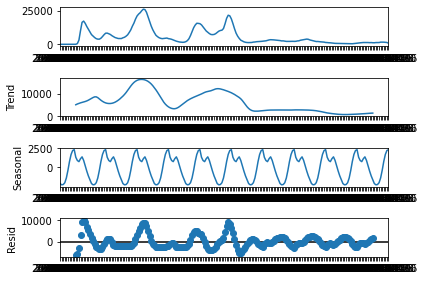

In [30]:
seasonal_period = 20
result = sm.tsa.seasonal_decompose(data, period=seasonal_period)
trend = result.trend
seasonal = result.seasonal
residual = result.resid
result.plot()
plt.show()

**additional temporal analysis done in R**
- histograms of the distribution of temporal features
- boxplots of covid-19 deaths by month and by week
- distributions of holidays and seasons

### ACF

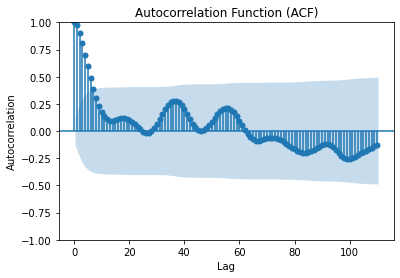

In [34]:
plot_acf(data['covid_19_deaths'], lags = 110)  # Adjust the number of lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

**PACF graph in midterm_code - part2**

### Stationarity Analysis

In [18]:
east = pd.read_csv('data/univar_data/east_daily.csv')
midwest = pd.read_csv('data/univar_data/midwest_daily.csv')
south = pd.read_csv('data/univar_data/south_daily.csv')
west = pd.read_csv('data/univar_data/west_daily.csv')

In [11]:
X = east.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.842138
p-value: 0.002504
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [13]:
X = midwest.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.473716
p-value: 0.122001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [35]:
X = south.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.104854
p-value: 0.026196
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [36]:
X = west.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.816341
p-value: 0.055977
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


midwest, south, and west are not stationary - ryan made stationary in R (new stationarity below)

In [37]:
# same east dataset
east_stationary = pd.read_csv('data/univar_data/east_daily.csv')

# new stationary datasets
midwest_stationary = pd.read_csv('data/univar_data/midwest_stationary.csv')
south_stationary = pd.read_csv('data/univar_data/south_stationary.csv')
west_stationary = pd.read_csv('data/univar_data/west_stationary.csv')

In [38]:
X = midwest_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.609058
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [39]:
X = south_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.154608
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [40]:
X = west_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.689075
p-value: 0.000001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


**additional univariate visualizations done in R**
- Those visualizations show that log transformations may be necessary.